In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# =========================
# IMPORT
# =========================
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import timm
from torch.optim.lr_scheduler import OneCycleLR

# =========================
# CONFIG
# =========================
classes = ['Aorta', 'Flows', 'Other', 'V sign', 'X sign']
NUM_CLASSES = len(classes)
IMG_SIZE = (299, 299)          # InceptionV4 chuẩn 299x299
BATCH_SIZE = 32
NUM_EPOCHS = 500
PATIENCE = 20
LR = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# DATASET
# =========================
class FetalEchoDataset(Dataset):
    def __init__(self, root_dir, phase='train', transform=None, x_sign_mode='both'):
        self.samples = []
        self.transform = transform
        self.classes = classes
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

        for cls in self.classes:
            if phase == 'train' and cls == 'X sign':
                folder = os.path.join(root_dir, phase, 'X sign', x_sign_mode)
            else:
                folder = os.path.join(root_dir, phase, cls)

            if not os.path.exists(folder):
                continue

            for f in os.listdir(folder):
                if f.endswith(('.jpg', '.png')):
                    self.samples.append(
                        (os.path.join(folder, f), self.class_to_idx[cls])
                    )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        return img, label

# =========================
# TRANSFORMS (GIỮ NGUYÊN)
# =========================
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomRotation(10)], p=0.75),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(1.0, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# =========================
# DATA LOADERS
# =========================
root = '/content/drive/MyDrive/Colab Notebooks/dataset/processedfetal_delation'

train_dataset = FetalEchoDataset(root, 'train', train_transforms, 'both')
val_dataset   = FetalEchoDataset(root, 'valid', val_test_transforms)
test_dataset  = FetalEchoDataset(root, 'test',  val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [3]:

# =========================
# MODEL – INCEPTION V4
# =========================
model = timm.create_model(
    'xception',
    pretrained=True,
    num_classes=NUM_CLASSES
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS
)

# =========================
# TRAINING + EARLY STOPPING
# =========================
best_f1 = 0.0
early_stop_counter = 0
best_model_path = '/content/drive/MyDrive/Colab Notebooks/model/baibaodautien/xception_best.pt'

for epoch in range(NUM_EPOCHS):
    # ---- TRAIN ----
    model.train()
    train_loss, correct, total = 0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    train_loss /= total
    train_acc = correct / total

    # ---- VALIDATION ----
    model.eval()
    val_loss, correct = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            val_loss += loss.item() * x.size(0)
            pred = out.argmax(1)

            correct += (pred == y).sum().item()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    val_loss /= len(val_dataset)
    val_acc = correct / len(val_dataset)
    val_f1 = f1_score(y_true, y_pred, average='macro')

    print(
        f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}"
    )

    # ---- EARLY STOPPING ----
    if val_f1 > best_f1:
        best_f1 = val_f1
        early_stop_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print("✅ Saved best model")
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print("⛔ Early stopping triggered")
            break



/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
Epoch [1/500] | Train Loss: 0.7730, Train Acc: 0.7789 | Val Loss: 0.3800, Val Acc: 0.8639, Val F1: 0.7515
✅ Saved best model
Epoch [2/500] | Train Loss: 0.1871, Train Acc: 0.9436 | Val Loss: 0.2680, Val Acc: 0.9031, Val F1: 0.8550
✅ Saved best model
Epoch [3/500] | Train Loss: 0.0943, Train Acc: 0.9732 | Val Loss: 0.2771, Val Acc: 0.9120, Val F1: 0.8651
✅ Saved best model
Epoch [4/500] | Train Loss: 0.0603, Train Acc: 0.9837 | Val Loss: 0.2123, Val Acc: 0.9379, Val F1: 0.9026
✅ Saved best model
Epoch [5/500] | Train Loss: 0.0470, Train Acc: 0.9870 | Val Loss: 0.2744, Val Acc: 0.9157, Val F1: 0.8505
Epoch [6/500] | Train Loss: 0.0357, Train Acc: 0.9900 | Val Loss: 0.2395, Val Acc: 0.9253, Val F1: 0.8844
Epoch [7/500] | Train Loss: 0.0339, Train Acc: 0.9915 | Val Loss: 0.2723, Val Acc: 0.9186, Val F1: 0.8536
Epo


Classification Report:
              precision    recall  f1-score   support

       Aorta       0.81      0.80      0.80       133
       Flows       0.96      1.00      0.98       219
       Other       0.98      0.92      0.95       689
      V sign       0.93      0.96      0.94       259
      X sign       0.70      0.91      0.79        79

    accuracy                           0.93      1379
   macro avg       0.88      0.92      0.89      1379
weighted avg       0.93      0.93      0.93      1379



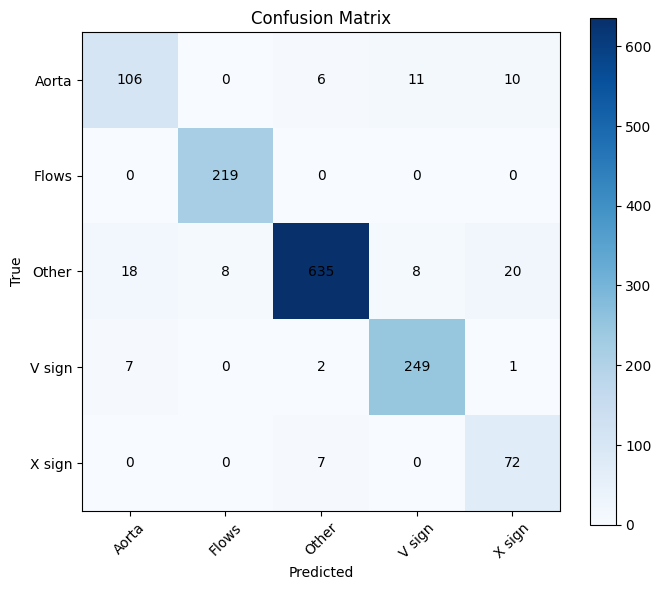

In [4]:
# =========================
# LOAD BEST MODEL
# =========================
model.load_state_dict(torch.load(best_model_path))
model.eval()

# =========================
# TEST + REPORT
# =========================
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        y_pred.extend(out.argmax(1).cpu().numpy())
        y_true.extend(y.numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(NUM_CLASSES), classes, rotation=45)
plt.yticks(range(NUM_CLASSES), classes)
plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.tight_layout()
plt.show()



===== VALIDATION SET EVALUATION =====
Classification Report (Validation):
              precision    recall  f1-score   support

       Aorta       0.83      0.97      0.89        96
       Flows       0.98      0.99      0.98       175
       Other       0.96      0.96      0.96       628
      V sign       0.98      0.98      0.98       362
      X sign       0.84      0.75      0.79        91

    accuracy                           0.95      1352
   macro avg       0.92      0.93      0.92      1352
weighted avg       0.95      0.95      0.95      1352



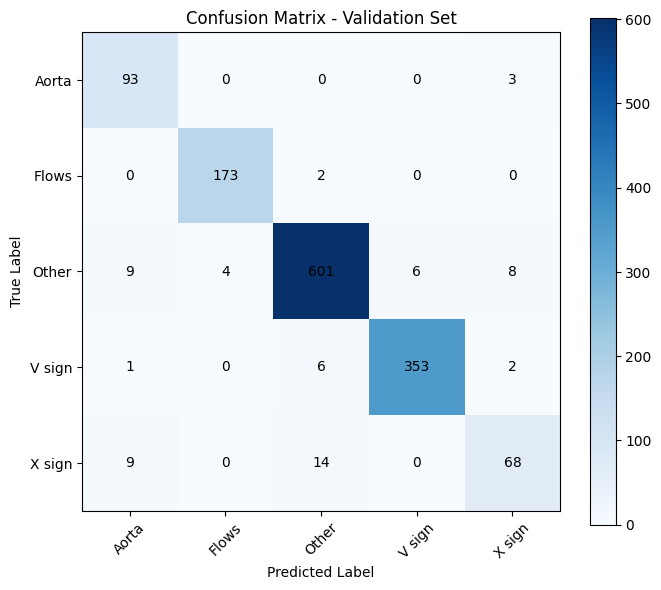

In [5]:
from sklearn.metrics import classification_report, confusion_matrix

# =========================
# VALIDATION EVALUATION
# =========================
y_val_true = []
y_val_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_val_true.extend(labels.cpu().numpy())
        y_val_pred.extend(preds.cpu().numpy())

print("\n===== VALIDATION SET EVALUATION =====")
print("Classification Report (Validation):")
print(classification_report(
    y_val_true,
    y_val_pred,
    target_names=classes
))

cm_val = confusion_matrix(y_val_true, y_val_pred)

# Vẽ confusion matrix
plt.figure(figsize=(7, 6))
plt.imshow(cm_val, cmap='Blues')
plt.title("Confusion Matrix - Validation Set")
plt.colorbar()
plt.xticks(range(len(classes)), classes, rotation=45)
plt.yticks(range(len(classes)), classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm_val[i, j],
                 ha="center", va="center", color="black")

plt.tight_layout()
plt.show()